In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt



# Camera Callibration:
CV2 functions findChessboardCorners and calibrateCamera were used to calculate the 
correct camera matrix and distortion coefficients using the calibration chessboard images 
provided in the repository

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

img_shape = cv2.imread(images[0])
x=img_shape.shape[1]
y=img_shape.shape[0]
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, (x,y), None, None)

### Display Function
 to print images passed in as arguments i.e. original image and processed image

In [3]:

def show_processed_img(img1,img2,img1_title="Original Image",img2_title="Processed Image"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(img1_title, fontsize=30)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(img2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

(720, 1280, 3)


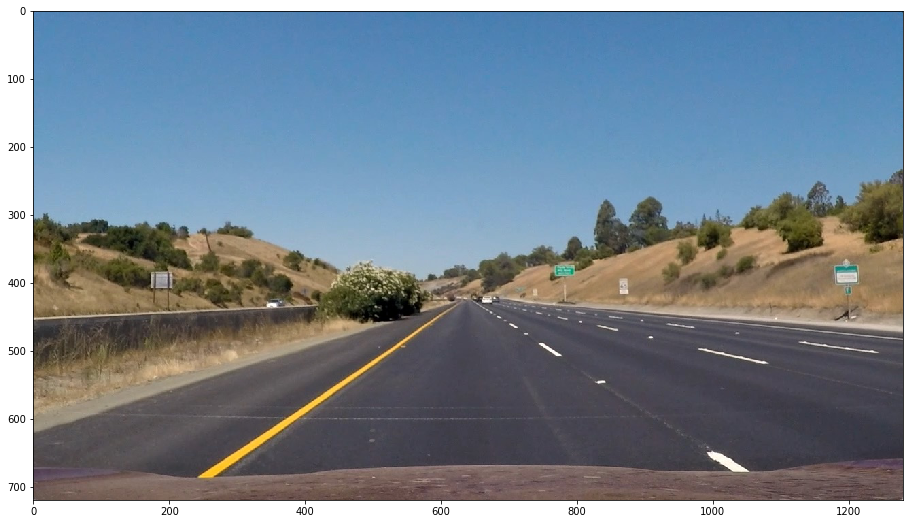

In [4]:
#Read an image
img1 = plt.imread("./test_images/straight_lines1.jpg")
print(img1.shape)
plt.rcParams['figure.figsize'] = (24,9)
plt.imshow(img1)

In [5]:
#Read an image
dist_img = plt.imread("./camera_cal/calibration5.jpg")


# Undistortion:
Undistort the images using the camera matrix and distortion coefficient.

In [6]:
def undistort(img,mtx,dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst

Distortion correction that was calculated via camera calibration has been
applied on a chess board image. An example of a distortion corrected 
image is as below

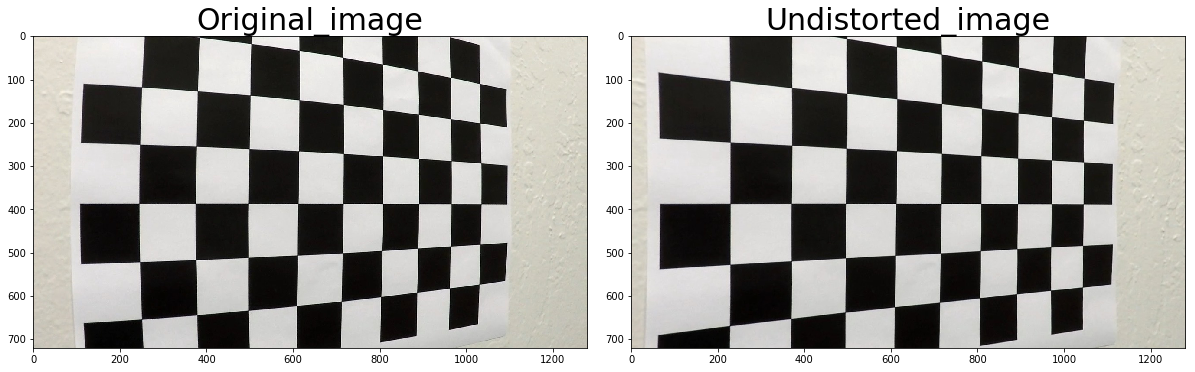

In [7]:
und=undistort(dist_img,mtx,dist)
show_processed_img(dist_img,und,"Original_image","Undistorted_image")

In [8]:
undistorted=undistort(img1,mtx,dist)

### Color Thresholding 
Color Thresholding has been applied on a undistorted image with respect to S color channel of HLS color spec. Applying this thesholding with minimum and maximum threshold values i.e. (190 and 255) I am able to get most of the lane line pixel.

In [9]:
def color_thresh(undistorted):
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    plt.rcParams['figure.figsize'] = (20, 25)
    s_channel = hls[:,:,2]
    output = np.zeros_like(s_channel)
    output[(s_channel > 190) & (s_channel < 255)] = 1
    return output


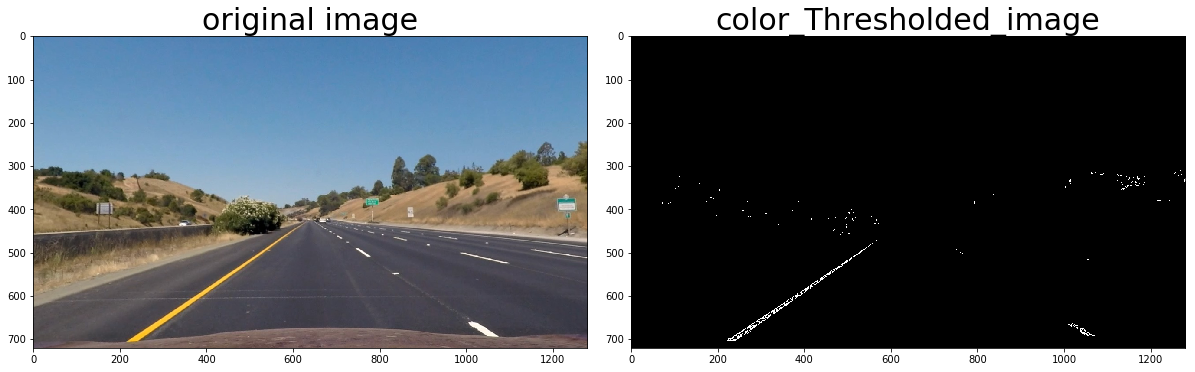

In [10]:
color=color_thresh(undistorted)
show_processed_img(undistorted,color,"original image", "color_Thresholded_image")

### Gradient Thresholding 
Magnitude  gradient thresholding has been applied on undistorted image with minimum and maximum threshold values of (90 and 255). This thresholding was giving result with most of the lane line pixel. 

In [11]:
def grad_thresh(img, sobel_kernel=3, mag_thresh=(90, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelxy=np.sqrt((sobelx)**2 + (sobely)**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    #absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #binary_output =  np.zeros_like(absgraddir)
    #binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return sxbinary


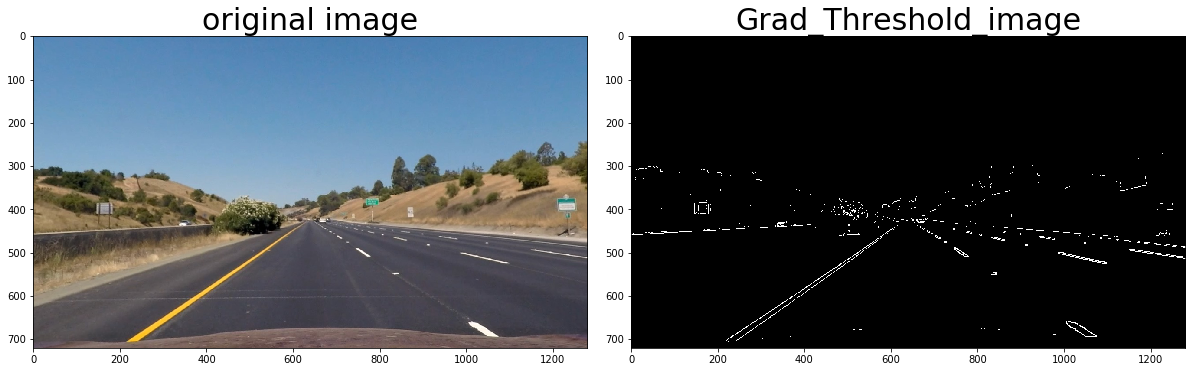

In [12]:
grad1=grad_thresh(undistorted)
show_processed_img(undistorted,grad1,"original image", "Grad_Threshold_image")

### Combined Thresholding :
 Althogh color and gradient thresholding was giving result but smaller dashed lane lines were not properly visible in color thresholding and gradient thresholding was able to identify these small lines . In order to get desired result we combined the result of both the gradient.
 

In [13]:
def combined_thresh(img, sobel_kernel=3, mag_thresh=(90, 255)):
    img1=color_thresh(img)
    img2= grad_thresh(img, sobel_kernel, mag_thresh)
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1== 1) | (img2 == 1)] = 1
    return combined_binary
    
    

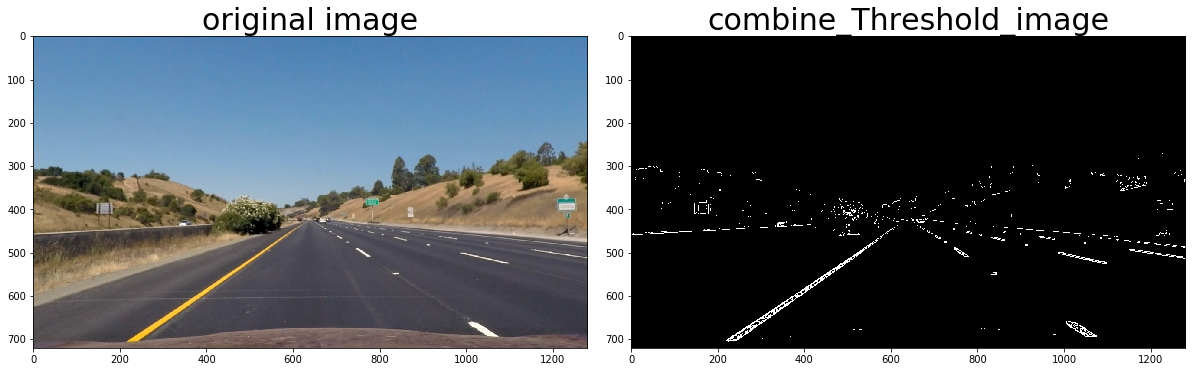

In [14]:
combined=combined_thresh(undistorted)
show_processed_img(undistorted,combined,"original image", "combine_Threshold_image")

### Warp function: 
This function will warp the provided image. As we know all the images are going to be the fixed size i have provided the source and destination point to warp the image. This function will return the binary warped image(Bird Eye View image) image and M inverse.

In [15]:
def warp(img):
    
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(
        [[685, 450],
          [1090, 710],
          [220, 710],
          [595, 450]])

    dst = np.float32(
        [[900, 0],
          [900, 710],
          [250, 710],
          [250, 0]])

    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return binary_warped,Minv


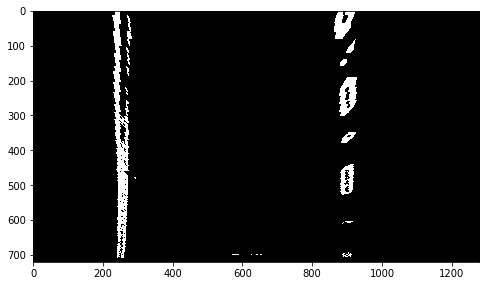

In [16]:
binary_warped, Minv=warp(combined)
plt.rcParams['figure.figsize'] = (8,5)
plt.imshow(binary_warped,cmap='gray')
#show_processed_img(color,img12)


### Histogram:

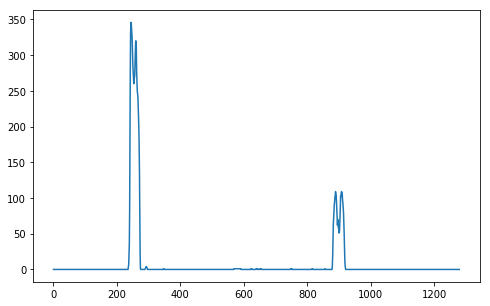

In [17]:
def get_histogram(binary_warped):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    return histogram


plt.rcParams['figure.figsize'] = (8,5)
histogram = get_histogram(binary_warped)
plt.plot(histogram)

### Sliding Window:
Sliding Window Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form. Skip Sliding Window is used to draw images with line pixels identified and a fit overplotted.

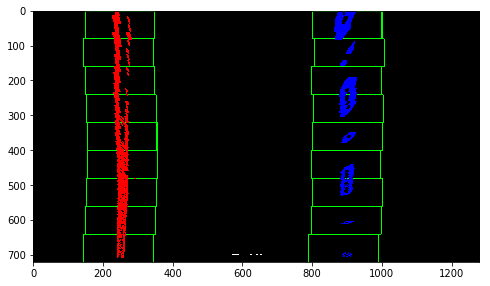

In [18]:
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.rcParams['figure.figsize'] = (8,5)
    plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit

ploty, left_fit, right_fit = sliding_window(binary_warped)

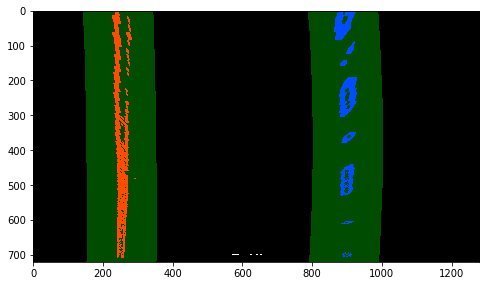

In [19]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #And you're done! But let's visualize the result here as well
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.rcParams['figure.figsize'] = (8,5)
    plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    dict1 = {}
    dict1['leftx'] = leftx
    dict1['rightx'] = rightx
    dict1['left_fitx'] = left_fitx
    dict1['right_fitx'] = right_fitx
    dict1['ploty'] = ploty

    return dict1


Line_info = skip_sliding_window(binary_warped, left_fit, right_fit)

### Draw lane line: 
This function will draw identified lane line on the original image and fill the polygon formed by the identified lane lines.

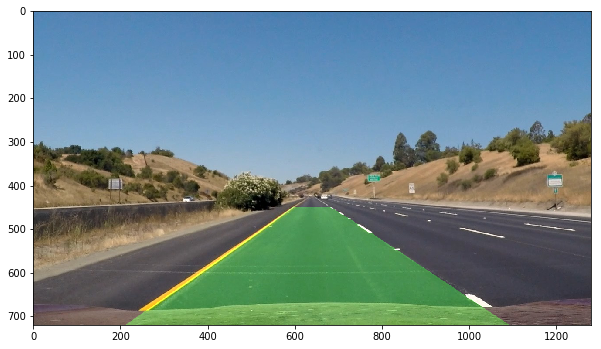

In [20]:
def draw_lane_lines(original_image,warped_image, Minv, Line_info):
    left_fitx = Line_info['left_fitx']
    right_fitx = Line_info['right_fitx']
    ploty = Line_info['ploty']

    warp_img_zero = np.zeros_like(warped_image).astype(np.uint8)
    colored_warp_img = np.dstack((warp_img_zero, warp_img_zero, warp_img_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(colored_warp_img, np.int_([pts]), (0,255, 0))

    newwarp_img = cv2.warpPerspective(colored_warp_img, Minv, (original_image.shape[1], original_image.shape[0]))
    result = cv2.addWeighted(original_image, 1, newwarp_img, 0.3, 0)

    return result


result = draw_lane_lines(img1, binary_warped, Minv, Line_info)
plt.rcParams['figure.figsize'] = (10,7)
plt.imshow(result)

In [21]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad




left_curverad, right_curverad = measure_curvature(ploty, Line_info)

In [22]:
global prev_warped
global used_Line

def process(image):
    global prev_warped
    global used_Line

    #Undistort image
    undistorted=undistort(image,mtx,dist)
    
    # Combine Gradient and Color thresholding
    combined_thr=combined_thresh(undistorted)
    
    #  Perspective Transform
    binary_warped, Minv = warp(combined_thr)

    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = sliding_window(binary_warped)

    # Skipping Sliding Window
    Line_info = skip_sliding_window(binary_warped, left_fit, right_fit)

    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, Line_info)

     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = Line_info['left_fitx'][0] - Line_info['left_fitx'][-1]
    slope_right = Line_info['right_fitx'][0] - Line_info['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 140
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000

    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = prev_warped
        Line_info = used_Line

    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, Line_info)

    # Annotating curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), font, 1.0, (255, 255, 255), 2)

    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(Line_info['right_fitx'][-1] - Line_info['left_fitx'][-1])
    xm_per_pix = 3.7/700
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), font, 1.0, (255, 255, 255), 2)

    prev_warped = binary_warped
    used_Line = Line_info

    return result

## Pipelines

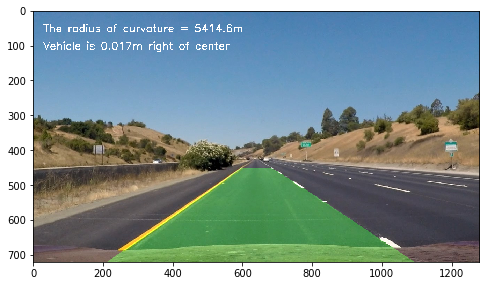

In [23]:
processed_image=process(img1)
plt.imshow(processed_image)

### Video Processing

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:32<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 5min 34s


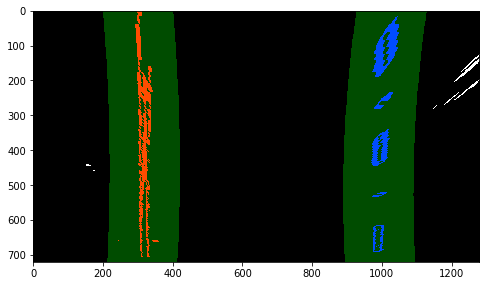

In [24]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process)
%time video_clip.write_videofile(output, audio=False)
